##Datathon

# WiDS Datathon 2024 - Resumen del Contexto y Dataset

## 📌 Descripción General

El **WiDS Datathon 2024** es una competencia de machine learning centrada en la predicción de intervalos de diagnóstico en oncología. El objetivo es predecir si el período de diagnóstico del cáncer de mama metastásico en una paciente fue menor a 90 días, utilizando un dataset que combina historiales clínicos, datos socioeconómicos y variables ambientales.

---

## 🎯 Variable Objetivo (Target)

**`DiagPeriodL90D`** (*Diagnosis Period Less Than 90 Days*)
-   **Tipo:** Variable Binaria (presumiblemente `1 = Sí`, `0 = No`).
-   **Qué representa:** Indica si el tiempo transcurrido hasta el diagnóstico del cáncer fue inferior a 90 días.
-   **Tarea de la competencia:** Predecir la **probabilidad** (valor entre 0 y 1) de que este evento sea cierto para cada paciente en el conjunto de prueba (`test.csv`).

---

## 📊 Fuentes de Datos

El dataset de entrenamiento (~18k registros) es una fusión de tres fuentes principales:

1.  **Health Verity (HV):** Registros de salud anonimizados de pacientes diagnosticadas con cáncer de mama triple negativo metastásico en EE.UU. (fuente principal de datos clínicos).
2.  **US Zip Codes Database:** Datos socioeconómicos y demográficos enriquecidos a nivel de código postal (zip code).
3.  **NASA/Columbia University:** Datos toxicológicos anuales de calidad del aire a nivel de zip code.

---

## 📁 Estructura de los Archivos

-   **`train.csv`:** Conjunto de entrenamiento. Contiene todas las características **más la variable objetivo** (`DiagPeriodL90D`).
-   **`test.csv`:** Conjunto de prueba. Contiene solo las características. **La variable objetivo debe ser predictha**.
-   **Formato de Entrega:** Un archivo (ej. `submission.csv`) con las columnas:
    ```csv
    patient_id, DiagPeriodL90D
    ```
    donde `DiagPeriodL90D` es la probabilidad predicha.

---

## 🧮 Categorías de Variables (Selección de las Más Relevantes)

### A. Datos del Paciente (Clínicos & Demográficos)
-   `patient_id`, `patient_age`, `patient_gender`, `patient_race`, `bmi`
-   `payer_type` (Tipo de seguro: Medicaid, Commercial, Medicare)
-   `breast_cancer_diagnosis_code`, `metastatic_cancer_diagnosis_code`
-   `metastatic_first_novel_treatment` (Primer tratamiento farmacológico)

### B. Ubicación Geográfica
-   `patient_state`, `patient_zip3`, `region`, `division`

### C. Datos Socioeconómicos del Zip Code (Extenso)
-   **Población:** `population`, `density`, `age_median`, `age_20s`, `age_30s`, ...
-   **Raza/Etnia:** `race_white`, `race_black`, `race_asian`, `hispanic`, ...
-   **Economía:** `income_household_median`, `home_value`, `rent_median`, `poverty`
-   **Educación:** `education_college_or_above`, `education_less_highschool`, ...
-   **Empleo:** `unemployment_rate`, `labor_force_participation`

### D. Calidad del Aire (Variables Clave del Contexto)
-   `ozone`: Concentración anual de Ozono (O3).
-   `PM25`: Concentración anual de Material Particulado Fino (PM2.5).
-   `N02`: Concentración anual de Dióxido de Nitrógeno (NO2).

---

## ⚠️ Notas Importantes

-   **Datos Externos:** El problema se puede resolver sin datos externos. Los datos están anonimizados, lo que dificulta hacer *joins* con datos externos, pero su uso está permitido.
-   **Valores Faltantes:** Es crucial chequear y manejar valores nulos, especialmente en columnas como `bmi`.
-   **Texto Libre:** La columna `breast_cancer_diagnosis_desc` contiene texto raw y podría requerir técnicas de NLP para su procesamiento.

### Próximos Pasos Sugeridos:
1.  Realizar un **Análisis Exploratorio de Datos (EDA)** exhaustivo.
2.  Analizar la distribución de la variable objetivo.
3.  Identificar y manejar missing values.
4.  Realizar ingeniería de características si es necesario.
5.  Entrenar y evaluar modelos de clasificación binaria.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import warnings

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score

In [2]:
df_datathon_training = pd.read_csv('widsdatathon2024-challenge1/training.csv', sep=',')
df_datathon_test = pd.read_csv('widsdatathon2024-challenge1/test.csv', sep=',') 

df_datathon_training.drop(columns = ['metastatic_first_novel_treatment','patient_id' ,'breast_cancer_diagnosis_desc', 'metastatic_first_novel_treatment_type'])
df_datathon_test.drop(columns = ['metastatic_first_novel_treatment','patient_id' ,'breast_cancer_diagnosis_desc', 'metastatic_first_novel_treatment_type']) 

,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,Region,...,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
0,White,MEDICAID,IN,467,54,F,NaN,C50412,C773,Midwest,...,3.564516,13.996774,7.985484,0.969355,24.955357,10.838710,8.080645,38.724876,7.947165,11.157161
1,NaN,COMMERCIAL,FL,337,52,F,NaN,C50912,C787,South,...,10.261538,16.020513,13.602564,2.836842,23.952632,10.579487,9.302564,36.918257,7.838973,13.599985
2,Hispanic,MEDICAID,CA,917,61,F,NaN,C50911,C773,West,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
3,Hispanic,MEDICARE ADVANTAGE,CA,917,64,F,NaN,C50912,C779,West,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
4,Black,NaN,CA,900,40,F,23.00,C50412,C779,West,...,45.526154,11.901538,20.760000,14.737500,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5787,White,NaN,KY,404,63,F,29.60,C50411,C773,South,...,1.243478,20.404348,20.813636,0.350000,30.152174,6.473913,5.908696,39.947326,7.622672,9.154618
5788,White,NaN,IA,507,69,F,NaN,C50912,C773,Midwest,...,6.175000,16.675000,15.900000,2.800000,16.800000,5.475000,6.875000,35.825340,7.610534,9.712786
5789,NaN,MEDICARE ADVANTAGE,WA,980,84,F,28.28,C50411,C773,West,...,9.511321,9.752830,6.432075,5.094340,31.275472,5.309434,5.807547,36.618644,4.939852,23.393650
5790,NaN,COMMERCIAL,OK,740,58,F,NaN,1749,C773,South,...,4.374627,15.544776,16.603030,0.513636,25.877273,14.926866,7.600000,39.832235,8.030925,9.769358


In [3]:
df_datathon_training.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


In [4]:
df_datathon_test.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
0,573710,White,MEDICAID,IN,467,54,F,NaN,C50412,Malig neoplasm of upper-outer quadrant of left...,...,3.564516,13.996774,7.985484,0.969355,24.955357,10.838710,8.080645,38.724876,7.947165,11.157161
1,593679,NaN,COMMERCIAL,FL,337,52,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,10.261538,16.020513,13.602564,2.836842,23.952632,10.579487,9.302564,36.918257,7.838973,13.599985
2,184532,Hispanic,MEDICAID,CA,917,61,F,NaN,C50911,Malignant neoplasm of unsp site of right femal...,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
3,447383,Hispanic,MEDICARE ADVANTAGE,CA,917,64,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
4,687972,Black,NaN,CA,900,40,F,23.0,C50412,Malig neoplasm of upper-outer quadrant of left...,...,45.526154,11.901538,20.760000,14.737500,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261


In [5]:
df_datathon_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

In [6]:
null_percentage = (round(df_datathon_training.isnull().mean()*100,2).to_frame(name='porcentaje_de_nulos').sort_values(by='porcentaje_de_nulos',ascending=False))
display(null_percentage)

,porcentaje_de_nulos
metastatic_first_novel_treatment,99.81
metastatic_first_novel_treatment_type,99.81
bmi,69.46
patient_race,49.47
payer_type,13.97
...,...
breast_cancer_diagnosis_code,0.00
patient_gender,0.00
patient_age,0.00
patient_zip3,0.00


In [7]:
df_datathon_training 

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,674178,White,NaN,OH,436,50,F,32.11,C50411,Malig neoplm of upper-outer quadrant of right ...,...,17.400000,23.600000,0.864706,19.841176,6.300000,6.247059,38.753055,8.068682,21.140731,1
12902,452909,NaN,COMMERCIAL,CA,945,50,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,11.243210,7.837037,5.411250,34.700000,3.845679,5.671605,36.469947,6.265266,10.728732,1
12903,357486,NaN,COMMERCIAL,CA,926,61,F,29.24,C50912,Malignant neoplasm of unspecified site of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,1
12904,935417,NaN,NaN,NY,112,37,F,31.00,1749,"Malignant neoplasm of breast (female), unspeci...",...,10.194737,18.642105,14.173684,42.502632,6.392105,1.755263,37.722740,7.879795,27.496367,0


In [8]:
df_datathon_training

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,674178,White,NaN,OH,436,50,F,32.11,C50411,Malig neoplm of upper-outer quadrant of right ...,...,17.400000,23.600000,0.864706,19.841176,6.300000,6.247059,38.753055,8.068682,21.140731,1
12902,452909,NaN,COMMERCIAL,CA,945,50,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,11.243210,7.837037,5.411250,34.700000,3.845679,5.671605,36.469947,6.265266,10.728732,1
12903,357486,NaN,COMMERCIAL,CA,926,61,F,29.24,C50912,Malignant neoplasm of unspecified site of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,1
12904,935417,NaN,NaN,NY,112,37,F,31.00,1749,"Malignant neoplasm of breast (female), unspeci...",...,10.194737,18.642105,14.173684,42.502632,6.392105,1.755263,37.722740,7.879795,27.496367,0


## variable BMI

<function matplotlib.pyplot.show(close=None, block=None)>

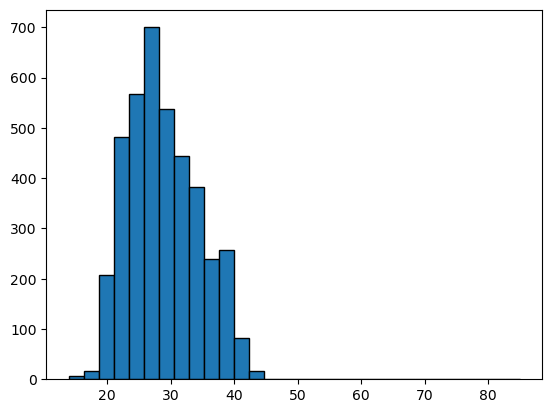

In [9]:
plt.hist(df_datathon_training['bmi'],bins=30,edgecolor='black')
plt.show

<Axes: xlabel='bmi', ylabel='Density'>

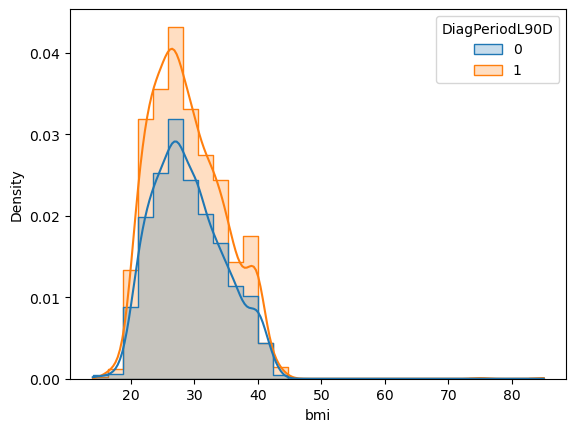

In [10]:
sns.histplot(data=df_datathon_training,x='bmi',hue='DiagPeriodL90D',bins=30,kde=True,element='step',stat='density')


In [11]:
df_datathon_training['bmi_cathegory'] = pd.cut(df_datathon_training['bmi'], bins=[0,18.5,24.9,29.9,34.9,39.9,np.inf], labels=['underweight','normal','overweight','obesity2','extreme'])


#df_datathon_training['bmi_cathegory'] df_datathon_training['bmi_cathegory'].fillna('unknown')

ValueError: Bin labels must be one fewer than the number of bin edges

In [12]:
df_datathon_training.drop(columns = ['bim'],inplace=True)

KeyError: "['bim'] not found in axis"

In [13]:
pd.crosstab

<function pandas.core.reshape.pivot.crosstab(index, columns, values=None, rownames=None, colnames=None, aggfunc=None, margins: 'bool' = False, margins_name: 'Hashable' = 'All', dropna: 'bool' = True, normalize: "bool | Literal[0, 1, 'all', 'index', 'columns']" = False) -> 'DataFrame'>

In [14]:
df_datathon_training['DiagPeriodL90D'].value_counts(normalize=True)

DiagPeriodL90D
1    0.624516
0    0.375484
Name: proportion, dtype: float64

In [15]:
df_datathon_training['patient_race'].value_counts(normalize=True)

patient_race
White       0.550222
Black       0.161938
Hispanic    0.127128
Other       0.104739
Asian       0.055973
Name: proportion, dtype: float64

In [16]:
df_datathon_training['patient_race'] = df_datathon_training['patient_race'].fillna('Unknown')
df_datathon_test['patient_race'] = df_datathon_test['patient_race'].fillna('Unknown')


In [17]:
df_datathon_training['payer_type'].value_counts(normalize=True)

payer_type
COMMERCIAL            0.543277
MEDICAID              0.231379
MEDICARE ADVANTAGE    0.225345
Name: proportion, dtype: float64

In [18]:
df_datathon_training['payer_type'] = df_datathon_training['payer_type'].fillna('No insurance')
df_datathon_test['payer_type'] = df_datathon_test['payer_type'].fillna('No insurance')


In [19]:
## si hay un valor nulo en una fila y el procentaje de valor nulo ya no es alto, podemos hacer un dropna
df_datathon_training.dropna()


,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
2025,670278,White,MEDICARE ADVANTAGE,OH,434,67,F,34.16,C50912,Malignant neoplasm of unspecified site of left...,...,15.657143,8.283333,0.195238,23.325641,5.728571,9.369048,38.621271,8.361093,15.788074,1
4290,731617,Black,COMMERCIAL,IN,462,41,F,33.95,C50411,Malig neoplm of upper-outer quadrant of right ...,...,12.751351,14.489189,2.813514,23.686111,8.537838,6.191892,37.225780,8.633946,20.938256,1
9057,337351,Black,MEDICAID,VA,238,51,F,29.70,C50919,Malignant neoplasm of unsp site of unspecified...,...,16.369231,10.334615,0.744231,31.830000,7.107692,12.114815,39.374101,6.907563,8.767393,1


#Rellenar valores nulos en dara set de Test

In [20]:
test_categories = df_datathon_test.select_dtypes(includes=['object']).nunique()
test_numeric= df_datathon_test.select_dtypes(includes=['number']).nunique()

TypeError: select_dtypes() got an unexpected keyword argument 'includes'

In [21]:
for category in test_categories:   
    df_datathon_test[category] = df_datathon_test[category].fillna(np.node(df_datathon_test[category]))
    

NameError: name 'test_categories' is not defined

In [ ]:
test_categories

In [ ]:
## codificacion de variables categoricas

In [ ]:
trianing_categories = df_datathon_training.select_dtypes(includes=['object']).columns.tolist()
trianing_numeric= df_datathon_training.select_dtypes(includes=['number']).columns.tolist()

TypeError: select_dtypes() got an unexpected keyword argument 'includes'

In [ ]:
df_training_encoded = pd.get_dummies(df_datathon_training,columns=trianing_categories, drop_first=False, dtype=int)
df_training_encoded.head()


NameError: name 'trianing_categories' is not defined

In [ ]:
#modelos ML
